<a href="https://colab.research.google.com/github/SupunGurusinghe/ML-with-superstore-dataset/blob/main/Superstore_Association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 45 kB/s 
     |████████████████████████████████| 199 kB 59.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=6dbb2f7aa9ab0877b365f6e33c34b5ffa2f5a78c3b1e8e3e5583715e6c191734
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

# **Data Preprocessing**

### **Importing packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### **Importing superstore dataset**

In [ ]:
url = "https://raw.githubusercontent.com/SupunGurusinghe/ML-with-superstore-dataset/main/superstore_data.csv"
superstore_df = pd.read_csv(url ,encoding='windows-1252')
superstore_df

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,NaN,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Suplease,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


### **Creating schema for data set**

In [ ]:
from pyspark.sql.types import *

sales_schema = StructType([
    StructField("RowID", IntegerType(), False),
    StructField("OrderID", StringType(), False),
    StructField("OrderDate", StringType(), False, metadata={"desc": "Date of order placed"}),
    StructField("ShipDate", StringType(), False, metadata={"desc": "Date of order shipped"}),
    StructField("ShipMode", StringType(), True, metadata={"desc": "Mode of shipment"}),
    StructField("CustomerID", StringType(), False),
    StructField("CustomerName", StringType(), True),
    StructField("Segment", StringType(), True, metadata={"desc": "Type of the customer"}),
    StructField("Country", StringType(), True),
    StructField("City", StringType(), False),
    StructField("State", StringType(), True),
    StructField("PostalCode", StringType(), True),
    StructField("Region", StringType(), True),
    StructField("ProductID", StringType(), False),
    StructField("Category", StringType(), True),
    StructField("SubCategory", StringType(), True),
    StructField("ProductName", StringType(), True),
    StructField("Sales", FloatType(), False),
    StructField("Quantity", IntegerType(), False),
    StructField("Discount", FloatType(), False),
    StructField("Profit", FloatType(), False),
])

### **Converting to PySpark dataframe**

In [ ]:
superstore_df = spark.createDataFrame(superstore_df, sales_schema)
superstore_df.show()

+-----+--------------+----------+----------+--------------+----------+------------------+-----------+-------------+---------------+--------------+----------+-------+---------------+---------------+-----------+--------------------+--------+--------+--------+--------+
|RowID|       OrderID| OrderDate|  ShipDate|      ShipMode|CustomerID|      CustomerName|    Segment|      Country|           City|         State|PostalCode| Region|      ProductID|       Category|SubCategory|         ProductName|   Sales|Quantity|Discount|  Profit|
+-----+--------------+----------+----------+--------------+----------+------------------+-----------+-------------+---------------+--------------+----------+-------+---------------+---------------+-----------+--------------------+--------+--------+--------+--------+
|    1|CA-2016-152156| 11/8/2016|11/11/2016|  Second Class|  CG-12520|       Claire Gute|   Consumer|United States|      Henderson|      Kentucky|     42420|  South|FUR-BO-10001798|            NaN|  

## **Handling null values**

### **Extract customer name and product category by using existing column values**

In [ ]:
from pyspark.sql import functions

df_1 = superstore_df.groupBy(superstore_df['CustomerID']).agg(functions.first(superstore_df['CustomerName'], ignorenulls=True))
df_2 = superstore_df.groupBy(superstore_df['ProductID']).agg(functions.first(superstore_df['Category'], ignorenulls=True))

df_1.show()
df_2.show()

+----------+--------------------+
|CustomerID| first(CustomerName)|
+----------+--------------------+
|  AA-10315|          Alex Avila|
|  AA-10375|        Allen Armold|
|  AA-10480|        Andrew Allen|
|  AA-10645|       Anna Andreadi|
|  AB-10015|       Aaron Bergman|
|  AB-10060|     Adam Bellavance|
|  AB-10105|       Adrian Barton|
|  AB-10150|         Aimee Bixby|
|  AB-10165|         Alan Barnes|
|  AB-10255|Alejandro Ballentine|
|  AB-10600|           Ann Blume|
|  AC-10420|       Alyssa Crouse|
|  AC-10450|             Amy Cox|
|  AC-10615|           Ann Chong|
|  AC-10660|          Anna Chung|
|  AD-10180|      Alan Dominguez|
|  AF-10870|        Art Ferguson|
|  AF-10885|          Art Foster|
|  AG-10270|     Alejandro Grove|
|  AG-10300| Aleksandra Gannaway|
+----------+--------------------+
only showing top 20 rows

+---------------+---------------+
|      ProductID|first(Category)|
+---------------+---------------+
|FUR-BO-10000112|      Furniture|
|FUR-BO-10000330|     

### **Join with newly extracted column values**

In [ ]:
df = superstore_df.select('RowID', 'OrderID','OrderDate', 'ShipDate', 'ShipMode', 'CustomerID','Segment','Country', 'City', 'State', 'PostalCode', 'Region', 'ProductID', 'SubCategory', 'ProductName', 'Sales', 'Quantity', 'Discount', 'Profit' )
df = df_1.join(df, 'CustomerID')
df.show()

+----------+-------------------+-----+--------------+----------+----------+--------------+---------+-------------+-------------+------------+----------+-------+---------------+-----------+--------------------+-------+--------+--------+--------+
|CustomerID|first(CustomerName)|RowID|       OrderID| OrderDate|  ShipDate|      ShipMode|  Segment|      Country|         City|       State|PostalCode| Region|      ProductID|SubCategory|         ProductName|  Sales|Quantity|Discount|  Profit|
+----------+-------------------+-----+--------------+----------+----------+--------------+---------+-------------+-------------+------------+----------+-------+---------------+-----------+--------------------+-------+--------+--------+--------+
|  VW-21775|    Victoria Wilson|  213|CA-2015-146262|  1/2/2015|  1/9/2015|Standard Class|Corporate|United States|       Medina|        Ohio|     44256|   East|OFF-LA-10004544|     Labels|           Avery 505|  23.68|       2|     0.2|    8.88|
|  VW-21775|    Vict

In [ ]:
df = df_2.join(df, 'ProductID')
df.show()

+---------------+---------------+----------+-------------------+-----+--------------+----------+----------+--------------+---------+-------------+-------------+------------+----------+-------+-----------+--------------------+-------+--------+--------+--------+
|      ProductID|first(Category)|CustomerID|first(CustomerName)|RowID|       OrderID| OrderDate|  ShipDate|      ShipMode|  Segment|      Country|         City|       State|PostalCode| Region|SubCategory|         ProductName|  Sales|Quantity|Discount|  Profit|
+---------------+---------------+----------+-------------------+-----+--------------+----------+----------+--------------+---------+-------------+-------------+------------+----------+-------+-----------+--------------------+-------+--------+--------+--------+
|OFF-LA-10004544|Office Supplies|  VW-21775|    Victoria Wilson|  213|CA-2015-146262|  1/2/2015|  1/9/2015|Standard Class|Corporate|United States|       Medina|        Ohio|     44256|   East|     Labels|           Av

### **Change column names and order them by `RowID`**

In [ ]:
df = df.select('RowID', 'OrderID','OrderDate', 'ShipDate', 'ShipMode', 'CustomerID', 'first(CustomerName)', 'Segment','Country', 'City', 'State', 'PostalCode', 'Region', 'ProductID', 'first(Category)', 'SubCategory', 'ProductName', 'Sales', 'Quantity', 'Discount', 'Profit' ).orderBy('RowID').withColumnRenamed("first(CustomerName)","CustomerName").withColumnRenamed("first(Category)","Category")
df.show()

+-----+--------------+----------+----------+--------------+----------+------------------+-----------+-------------+---------------+--------------+----------+-------+---------------+---------------+-----------+--------------------+--------+--------+--------+--------+
|RowID|       OrderID| OrderDate|  ShipDate|      ShipMode|CustomerID|      CustomerName|    Segment|      Country|           City|         State|PostalCode| Region|      ProductID|       Category|SubCategory|         ProductName|   Sales|Quantity|Discount|  Profit|
+-----+--------------+----------+----------+--------------+----------+------------------+-----------+-------------+---------------+--------------+----------+-------+---------------+---------------+-----------+--------------------+--------+--------+--------+--------+
|    1|CA-2016-152156| 11/8/2016|11/11/2016|  Second Class|  CG-12520|       Claire Gute|   Consumer|United States|      Henderson|      Kentucky|     42420|  South|FUR-BO-10001798|            NaN|  

### **Setting defaults value for null values**


In [ ]:
df = df.na.fill({
    "ShipMode": "EMPTY",
    "Segment": "EMPTY",
    "Country": "EMPTY",
    "PostalCode": "EMPTY",
    "Region": "EMPTY",
    "Segment": "EMPTY",
    "SubCategory": "EMPTY",
    "ProductName": "EMPTY",
})

df.show()

+-----+--------------+----------+----------+--------------+----------+------------------+-----------+-------------+---------------+--------------+----------+-------+---------------+---------------+-----------+--------------------+--------+--------+--------+--------+
|RowID|       OrderID| OrderDate|  ShipDate|      ShipMode|CustomerID|      CustomerName|    Segment|      Country|           City|         State|PostalCode| Region|      ProductID|       Category|SubCategory|         ProductName|   Sales|Quantity|Discount|  Profit|
+-----+--------------+----------+----------+--------------+----------+------------------+-----------+-------------+---------------+--------------+----------+-------+---------------+---------------+-----------+--------------------+--------+--------+--------+--------+
|    1|CA-2016-152156| 11/8/2016|11/11/2016|  Second Class|  CG-12520|       Claire Gute|   Consumer|United States|      Henderson|      Kentucky|     42420|  South|FUR-BO-10001798|            NaN|  

### **Convert to a pandas DataFrame**

In [ ]:
df = df.toPandas()
df

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,NaN,Bookcases,Bush Somerset Collection Bookcase,261.959991,2,0.00,41.913601
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940002,3,0.00,219.582001
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620000,2,0.00,6.871400
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.577515,5,0.45,-383.031006
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Suplease,Storage,Eldon Fold 'N Roll Cart System,22.368000,2,0.20,2.516400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.247999,3,0.20,4.102800
9990,9991,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.959999,2,0.00,15.633200
9991,9992,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.575989,2,0.20,19.393200
9992,9993,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600000,4,0.00,13.320000


## **Handling spelling mistakes**

In [ ]:
df.Category.value_counts()

Office Supplies    5987
Furniture          2118
Technology         1836
NaN                  30
Office Suplease      23
Name: Category, dtype: int64

In [ ]:
df.loc[df.Category == 'Office Suplease' , 'Category'] = 'Office Supplies'

In [ ]:
df.Category.value_counts()

Office Supplies    6010
Furniture          2118
Technology         1836
NaN                  30
Name: Category, dtype: int64

## **Duplicates Handling**

In [ ]:
df.shape

(9994, 21)

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.loc[df.duplicated(keep = False)]

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit


In [ ]:
df.loc[df.duplicated(subset = ['OrderID','CustomerID','ProductID'],keep = False)]

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
26,27,CA-2016-121755,1/16/2016,1/20/2016,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,...,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570000,3,0.0,11.774100
50,51,CA-2016-121755,1/16/2016,1/20/2016,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,...,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570000,6,0.0,11.774100
350,351,CA-2016-129714,9/1/2016,9/3/2016,First Class,AB-10060,Adam Bellavance,Home Office,United States,New York City,...,10009,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,24.559999,2,0.0,11.543200
352,353,CA-2016-129714,9/1/2016,9/3/2016,First Class,AB-10060,Adam Bellavance,Home Office,United States,New York City,...,10009,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,49.119999,4,0.0,23.086399
430,431,US-2016-123750,4/15/2016,4/21/2016,Standard Class,RB-19795,Ross Baird,Home Office,United States,Gastonia,...,28052,South,TEC-AC-10004659,Technology,Accessories,Imation Secure+ Hardware Encrypted USB 2.0 Fla...,408.743988,7,0.2,76.639503
431,432,US-2016-123750,4/15/2016,4/21/2016,Standard Class,RB-19795,Ross Baird,Home Office,United States,Gastonia,...,28052,South,TEC-AC-10004659,Technology,Accessories,Imation Secure+ Hardware Encrypted USB 2.0 Fla...,291.959991,5,0.2,54.742500
566,567,CA-2017-156951,10/1/2017,10/8/2017,Standard Class,EB-13840,Ellis Ballard,Corporate,United States,Seattle,...,98105,West,OFF-PA-10004530,Office Supplies,Paper,Personal Creations Ink Jet Cards and Labels,91.839996,8,0.0,45.001598
695,696,CA-2017-156951,10/1/2017,10/8/2017,Standard Class,EB-13840,Ellis Ballard,Corporate,United States,Seattle,...,98105,West,OFF-PA-10004530,Office Supplies,Paper,Personal Creations Ink Jet Cards and Labels,91.839996,4,0.0,45.001598
750,751,CA-2017-126074,10/2/2017,10/6/2017,Standard Class,RF-19735,Roland Fjeld,Consumer,United States,Trenton,...,48183,Central,FUR-FU-10003577,Furniture,Furnishings,Nu-Dell Leatherette Frames,157.740005,11,0.0,56.786400
876,877,CA-2017-126074,10/2/2017,10/6/2017,Standard Class,RF-19735,Roland Fjeld,Consumer,United States,Trenton,...,48183,Central,FUR-FU-10003577,Furniture,Furnishings,Nu-Dell Leatherette Frames,157.740005,1,0.0,56.786400


In [ ]:
df.drop_duplicates(subset = ['OrderID','CustomerID','ProductID'], keep = 'last', inplace=True)

In [ ]:
df.loc[df.duplicated(subset = ['OrderID','CustomerID','ProductID'],keep = False)]

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit


In [ ]:
df.head()

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,NaN,Bookcases,Bush Somerset Collection Bookcase,261.959991,2,0.00,41.913601
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940002,3,0.00,219.582001
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620000,2,0.00,6.871400
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.577515,5,0.45,-383.031006
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368000,2,0.20,2.516400


## **Handling Fixed Bounds**

##Sales are bounded for positive values

##Therefore checking whether having negative values for sales

In [ ]:
(df.Sales < 0).any()

False

##Quantity is bounded for positive values

##Therefore checking whether having negative values for quantity

In [ ]:
(df.Quantity < 0).any()

False

##Profit is usually bounded by positive values

##Therefore checking whether having negative values for profit



In [ ]:
(df.Profit < 0).any()

True

##We can consider negative profits to represent the loss

In [ ]:
df.query('Profit < 0')

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.577515,5,0.45,-383.031006
14,15,US-2015-118983,11/22/2015,11/26/2015,Standard Class,HP-14815,Harold Pawlan,Home Office,United States,Fort Worth,...,76106,Central,OFF-AP-10002311,Office Supplies,Appliances,Holmes Replacement Filter for HEPA Air Cleaner...,68.809998,5,0.80,-123.858002
15,16,US-2015-118983,11/22/2015,11/26/2015,Standard Class,HP-14815,Harold Pawlan,Home Office,United States,Fort Worth,...,76106,Central,OFF-BI-10000756,Office Supplies,Binders,Storex DuraTech Recycled Plastic Frosted Binders,2.544000,3,0.80,-3.816000
23,24,US-2017-156909,7/16/2017,7/18/2017,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,...,19140,East,FUR-CH-10002774,Furniture,Chairs,"Global Deluxe Stacking Chair, Gray",71.372002,2,0.30,-1.019600
27,28,US-2015-150630,9/17/2015,9/21/2015,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.429932,7,0.50,-1665.052246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9920,9921,CA-2016-149272,3/15/2016,3/19/2016,Standard Class,MY-18295,Muhammed Yedwab,Corporate,United States,Bryan,...,77803,Central,OFF-BI-10004233,Office Supplies,Binders,"GBC Pre-Punched Binding Paper, Plastic, White,...",22.386000,7,0.80,-35.817600
9921,9922,CA-2014-111360,11/24/2014,11/30/2014,Standard Class,AT-10435,Alyssa Tate,Home Office,United States,Akron,...,44312,East,OFF-BI-10003350,Office Supplies,Binders,Acco Expandable Hanging Binders,5.742000,3,0.70,-4.593600
9931,9932,CA-2015-104948,11/13/2015,11/17/2015,Standard Class,KH-16510,Keith Herrera,Consumer,United States,San Bernardino,...,92404,West,FUR-BO-10004357,Furniture,Bookcases,O'Sullivan Living Dimensions 3-Shelf Bookcases,683.331970,4,0.15,-40.195999
9937,9938,CA-2016-164889,6/3/2016,6/6/2016,Second Class,CP-12340,Christine Phan,Corporate,United States,Los Angeles,...,90049,West,FUR-TA-10001676,Furniture,Tables,Hon 61000 Series Interactive Training Tables,71.087997,2,0.20,-1.777200


##Discount is bounded for positive values

##Therefore checking whether having negative values for Discount

In [ ]:
(df.Discount < 0).any()

True

In [ ]:
len(df.query('Discount < 0'))

17

##There are 17 negative values for discount.

##It is probably a mistake.

In [ ]:
df.query('Discount < 0')

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
1173,1174,US-2015-104430,10/22/2015,10/26/2015,Standard Class,LT-17110,Liz Thompson,Consumer,United States,Bloomington,...,61701,Central,OFF-BI-10000301,Office Supplies,Binders,GBC Instant Report Kit,5.176000,4,-0.8,-7.764000
1271,1272,US-2016-103646,4/21/2016,4/26/2016,Standard Class,SP-20545,Sibella Parks,Corporate,United States,Chicago,...,60623,Central,OFF-AP-10004487,Office Supplies,Appliances,Kensington 4 Outlet MasterPiece Compact Power ...,48.792000,3,-0.8,-126.859200
1284,1285,US-2015-149692,12/6/2015,12/12/2015,Standard Class,KW-16435,Katrina Willman,Consumer,United States,Austin,...,78745,Central,OFF-BI-10002813,Office Supplies,Binders,Avery Reinforcements for Hole-Punch Pages,2.772000,7,-0.8,-4.851000
1332,1333,CA-2014-122567,2/16/2014,2/21/2014,Standard Class,MN-17935,Michael Nguyen,Consumer,United States,Dallas,...,75220,Central,OFF-BI-10002012,Office Supplies,Binders,Wilson Jones Easy Flow II Sheet Lifters,1.080000,3,-0.8,-1.728000
1513,1514,CA-2017-112809,8/18/2017,8/22/2017,Standard Class,RA-19915,Russell Applegate,Consumer,United States,Dallas,...,75220,Central,OFF-BI-10001098,Office Supplies,Binders,Acco D-Ring Binder w/DublLock,21.379999,5,-0.8,-33.139000
1770,1771,CA-2017-146024,3/2/2017,3/8/2017,Standard Class,SC-20770,Stewart Carmichael,Corporate,United States,Dallas,...,75081,Central,OFF-BI-10003291,Office Supplies,Binders,Wilson Jones Leather-Like Binders with DublLoc...,12.222000,7,-0.8,-20.166300
1818,1819,US-2014-130379,5/25/2014,5/29/2014,Standard Class,JL-15235,Janet Lee,Consumer,United States,Chicago,...,60623,Central,OFF-AP-10001394,Office Supplies,Appliances,Harmony Air Purifier,75.599998,2,-0.8,-166.320007
1820,1821,CA-2016-168956,2/16/2016,2/20/2016,Standard Class,EA-14035,Erin Ashbrook,Corporate,United States,Chicago,...,60623,Central,OFF-AP-10004233,Office Supplies,Appliances,Honeywell Enviracaire Portable Air Cleaner for...,92.064003,6,-0.8,-225.556793
1857,1858,US-2017-158218,5/12/2017,5/15/2017,Second Class,AC-10420,Alyssa Crouse,Corporate,United States,Houston,...,77041,Central,OFF-BI-10002133,Office Supplies,Binders,"Wilson Jones Elliptical Ring 3 1/2"" Capacity B...",34.240002,4,-0.8,-53.071999
1943,1944,CA-2017-144064,8/29/2017,9/1/2017,First Class,CP-12085,Cathy Prescott,Corporate,United States,Quincy,...,62301,Central,OFF-BI-10002012,Office Supplies,Binders,Wilson Jones Easy Flow II Sheet Lifters,3.240000,9,-0.8,-5.184000


In [ ]:
neg_Discount = df[df.Discount < 0]
neg_Discount

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
1173,1174,US-2015-104430,10/22/2015,10/26/2015,Standard Class,LT-17110,Liz Thompson,Consumer,United States,Bloomington,...,61701,Central,OFF-BI-10000301,Office Supplies,Binders,GBC Instant Report Kit,5.176000,4,-0.8,-7.764000
1271,1272,US-2016-103646,4/21/2016,4/26/2016,Standard Class,SP-20545,Sibella Parks,Corporate,United States,Chicago,...,60623,Central,OFF-AP-10004487,Office Supplies,Appliances,Kensington 4 Outlet MasterPiece Compact Power ...,48.792000,3,-0.8,-126.859200
1284,1285,US-2015-149692,12/6/2015,12/12/2015,Standard Class,KW-16435,Katrina Willman,Consumer,United States,Austin,...,78745,Central,OFF-BI-10002813,Office Supplies,Binders,Avery Reinforcements for Hole-Punch Pages,2.772000,7,-0.8,-4.851000
1332,1333,CA-2014-122567,2/16/2014,2/21/2014,Standard Class,MN-17935,Michael Nguyen,Consumer,United States,Dallas,...,75220,Central,OFF-BI-10002012,Office Supplies,Binders,Wilson Jones Easy Flow II Sheet Lifters,1.080000,3,-0.8,-1.728000
1513,1514,CA-2017-112809,8/18/2017,8/22/2017,Standard Class,RA-19915,Russell Applegate,Consumer,United States,Dallas,...,75220,Central,OFF-BI-10001098,Office Supplies,Binders,Acco D-Ring Binder w/DublLock,21.379999,5,-0.8,-33.139000
1770,1771,CA-2017-146024,3/2/2017,3/8/2017,Standard Class,SC-20770,Stewart Carmichael,Corporate,United States,Dallas,...,75081,Central,OFF-BI-10003291,Office Supplies,Binders,Wilson Jones Leather-Like Binders with DublLoc...,12.222000,7,-0.8,-20.166300
1818,1819,US-2014-130379,5/25/2014,5/29/2014,Standard Class,JL-15235,Janet Lee,Consumer,United States,Chicago,...,60623,Central,OFF-AP-10001394,Office Supplies,Appliances,Harmony Air Purifier,75.599998,2,-0.8,-166.320007
1820,1821,CA-2016-168956,2/16/2016,2/20/2016,Standard Class,EA-14035,Erin Ashbrook,Corporate,United States,Chicago,...,60623,Central,OFF-AP-10004233,Office Supplies,Appliances,Honeywell Enviracaire Portable Air Cleaner for...,92.064003,6,-0.8,-225.556793
1857,1858,US-2017-158218,5/12/2017,5/15/2017,Second Class,AC-10420,Alyssa Crouse,Corporate,United States,Houston,...,77041,Central,OFF-BI-10002133,Office Supplies,Binders,"Wilson Jones Elliptical Ring 3 1/2"" Capacity B...",34.240002,4,-0.8,-53.071999
1943,1944,CA-2017-144064,8/29/2017,9/1/2017,First Class,CP-12085,Cathy Prescott,Corporate,United States,Quincy,...,62301,Central,OFF-BI-10002012,Office Supplies,Binders,Wilson Jones Easy Flow II Sheet Lifters,3.240000,9,-0.8,-5.184000


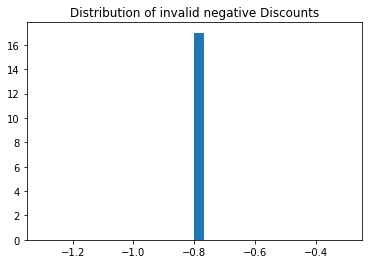

In [ ]:
plt.hist(neg_Discount.Discount, bins=30)
plt.title("Distribution of invalid negative Discounts");

In [ ]:
neg_Discount.Discount.value_counts()

-0.8    17
Name: Discount, dtype: int64

In [ ]:
toBeRemove = df[(df['Discount'] == -0.8)].index
df.drop(toBeRemove , inplace=True)
toBeRemove

Int64Index([1173, 1271, 1284, 1332, 1513, 1770, 1818, 1820, 1857, 1943, 1972,
            1995, 2004, 2106, 2137, 2159, 2167],
           dtype='int64')

In [ ]:
df.query('Discount < 0')

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit


##After considering negative discount values we can conclude that,

###1. There is only one negative discount value which is -0.8.

###2. Total count of orders is 9994. Among 9994 orders 17 negative discount values are *negligible*.

###3. Therefore we can drop those rows from dataset.

## **Remove Outliers**

In [ ]:
#Boxplot
def plot_boxplot(df , ft):
  df.boxplot(column = [ft])
  plt.grid(False)
  plt.show()

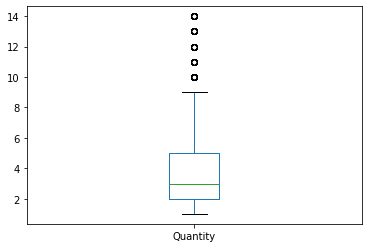

In [ ]:
plot_boxplot(df, 'Quantity')

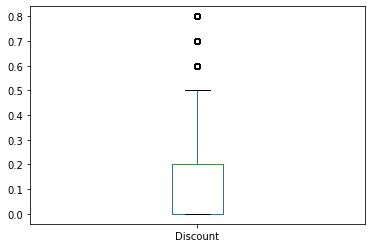

In [ ]:
plot_boxplot(df , 'Discount')

In [ ]:
# IQR = Q3-Q1

def outliers(df , ft):
  Q1 = df[ft].quantile(0.25)
  Q3 = df[ft].quantile(0.75)
  IQR = Q3-Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  ls = df.index[ (df[ft] < lower_bound) | (df[ft] > upper_bound) ]

  return ls

In [ ]:
outlier_indexes = []
for feature in ['Quantity' , 'Discount']:
  outlier_indexes.extend(outliers(df , feature))

In [ ]:
len(outlier_indexes)

1007

In [ ]:
def remove(df , ls):
  ls = sorted(set(ls))
  df = df.drop(ls)

  return df

In [ ]:
dataset_new =remove(df , outlier_indexes)

In [ ]:
dataset_new.shape

(8970, 21)

In [ ]:
df.shape

(9965, 21)

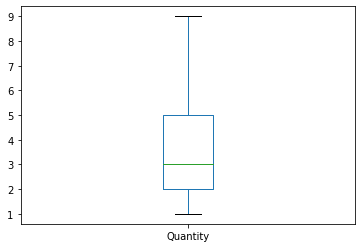

In [ ]:
plot_boxplot(dataset_new , 'Quantity')

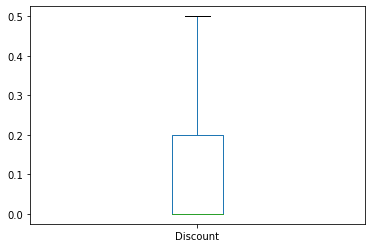

In [ ]:
plot_boxplot(dataset_new , 'Discount')

In [ ]:
df = dataset_new

In [ ]:
df

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,NaN,Bookcases,Bush Somerset Collection Bookcase,261.959991,2,0.00,41.913601
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940002,3,0.00,219.582001
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620000,2,0.00,6.871400
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.577515,5,0.45,-383.031006
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368000,2,0.20,2.516400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.247999,3,0.20,4.102800
9990,9991,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.959999,2,0.00,15.633200
9991,9992,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.575989,2,0.20,19.393200
9992,9993,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600000,4,0.00,13.320000


## **Association Rule Mining**

In [ ]:
df.head()

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,NaN,Bookcases,Bush Somerset Collection Bookcase,261.959991,2,0.00,41.913601
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940002,3,0.00,219.582001
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620000,2,0.00,6.871400
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.577515,5,0.45,-383.031006
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368000,2,0.20,2.516400


In [ ]:
df.columns

Index(['RowID', 'OrderID', 'OrderDate', 'ShipDate', 'ShipMode', 'CustomerID',
       'CustomerName', 'Segment', 'Country', 'City', 'State', 'PostalCode',
       'Region', 'ProductID', 'Category', 'SubCategory', 'ProductName',
       'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [ ]:
df.shape

(8970, 21)

In [ ]:
0,1,2,5,13,16,18

(0, 1, 2, 5, 13, 16, 18)

### **Filter Columns**

In [ ]:
df_association = df.drop(df.columns[[0,3,4,6,7,8,9,11,12,14,15,17,19,20]],axis = 1)
df_association

,OrderID,OrderDate,CustomerID,State,ProductID,ProductName,Quantity
0,CA-2016-152156,11/8/2016,CG-12520,Kentucky,FUR-BO-10001798,Bush Somerset Collection Bookcase,2
1,CA-2016-152156,11/8/2016,CG-12520,Kentucky,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",3
2,CA-2016-138688,6/12/2016,DV-13045,California,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,2
3,US-2015-108966,10/11/2015,SO-20335,Florida,FUR-TA-10000577,Bretford CR4500 Series Slim Rectangular Table,5
4,US-2015-108966,10/11/2015,SO-20335,Florida,OFF-ST-10000760,Eldon Fold 'N Roll Cart System,2
...,...,...,...,...,...,...,...
9989,CA-2014-110422,1/21/2014,TB-21400,Florida,FUR-FU-10001889,Ultra Door Pull Handle,3
9990,CA-2017-121258,2/26/2017,DB-13060,California,FUR-FU-10000747,Tenex B1-RE Series Chair Mats for Low Pile Car...,2
9991,CA-2017-121258,2/26/2017,DB-13060,California,TEC-PH-10003645,Aastra 57i VoIP phone,2
9992,CA-2017-121258,2/26/2017,DB-13060,California,OFF-PA-10004041,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",4


In [ ]:
# import libraries
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
df_association.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8970 entries, 0 to 9993
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   OrderID      8970 non-null   object
 1   OrderDate    8970 non-null   object
 2   CustomerID   8970 non-null   object
 3   State        8970 non-null   object
 4   ProductID    8970 non-null   object
 5   ProductName  8970 non-null   object
 6   Quantity     8970 non-null   int32 
dtypes: int32(1), object(6)
memory usage: 525.6+ KB


In [ ]:
#df.isna().sum() 
df_association.shape

(8970, 7)

In [ ]:
print(df_association.ProductID.nunique())
print(df_association.ProductName.nunique())

1847
1835


The unique values above two columns must be equal , because each product ID represent a product

In [ ]:
#df_association_product
df_association_product = df_association[["ProductName","ProductID"]].drop_duplicates()
df_association_product = df_association_product.groupby(["ProductName"]).agg({"ProductID":"count"}).reset_index()
df_association_product.sort_values("ProductID", ascending=False).head()


,ProductName,ProductID
1485,Staples,10
1479,Staple envelope,9
534,Easy-staple paper,8
1486,Staples in misc. colors,7
1482,Staple remover,3


In [ ]:
df_association_product.rename(columns={'ProductID':'ProductID_Count'},inplace=True)

df_association_product = df_association_product[df_association_product["ProductID_Count"]>1]

#### Delete products with more than more ProductID

In [ ]:
df_association = df_association[~df_association["ProductName"].isin(df_association_product["ProductName"])]

In [ ]:
print(df_association.ProductID.nunique())
print(df_association.ProductName.nunique())

1787
1819


In [ ]:
#df_association_product
df_association_product = df_association[["ProductName","ProductID"]].drop_duplicates()
df_association_product = df_association_product.groupby(["ProductID"]).agg({"ProductName":"count"}).reset_index()
df_association_product.rename(columns={'ProductName':'ProductName_Count'},inplace=True)

In [ ]:
df_association_product = df_association_product.sort_values("ProductName_Count", ascending=False)
df_association_product.head()

,ProductID,ProductName_Count
1453,TEC-AC-10002049,2
1357,OFF-ST-10004950,2
1684,TEC-PH-10002200,2
696,OFF-BI-10002026,2
1100,OFF-PA-10002195,2


In [ ]:
df_association_product = df_association_product[df_association_product["ProductName_Count"] > 1] 
df_association_product.head()

,ProductID,ProductName_Count
1453,TEC-AC-10002049,2
1357,OFF-ST-10004950,2
1684,TEC-PH-10002200,2
696,OFF-BI-10002026,2
1100,OFF-PA-10002195,2


**delete product id that represents multiple products**

In [ ]:
df_association = df_association[~df_association["ProductID"].isin(df_association_product["ProductID"])]

**Now each product id represent a single product**

In [ ]:
print(df_association.ProductID.nunique())
print(df_association.ProductName.nunique())

1755
1755


In [ ]:
df_California = df[df["State"] == "California"]
df_California.shape

(1963, 21)

In [ ]:
df_Florida = df[df["State"] == "Florida"]
df_Florida.shape

(312, 21)

In [ ]:
df_Texas = df[df["State"] == "Texas"]
df_Texas.shape


(695, 21)

In [ ]:
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['OrderID', 'ProductID'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['OrderID', 'ProductName'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [ ]:
gr_inv_pro_df = create_invoice_product_df(df_association, id=True)
gr_inv_pro_df.head()

ProductID,FUR-BO-10000112,FUR-BO-10000330,FUR-BO-10000362,FUR-BO-10000468,FUR-BO-10000711,FUR-BO-10000780,FUR-BO-10001337,FUR-BO-10001519,FUR-BO-10001601,FUR-BO-10001608,...,TEC-PH-10004833,TEC-PH-10004875,TEC-PH-10004896,TEC-PH-10004897,TEC-PH-10004908,TEC-PH-10004912,TEC-PH-10004922,TEC-PH-10004924,TEC-PH-10004959,TEC-PH-10004977
OrderID,,,,,,,,,,,,,,,,,,,,,
CA-2014-100006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2014-100090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2014-100293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2014-100328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2014-100363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Define a function to find the product name corresponding to the product ID**

In [ ]:
def check_id(dataframe, productid):
    product_name = dataframe[dataframe["ProductID"] == productid]["ProductName"].unique()[0]
    return productid, product_name

In [ ]:
check_id(df_California, 'TEC-PH-10004922')

('TEC-PH-10004922', 'RCA Visys Integrated PBX 8-Line Router')

In [ ]:
check_id(df_California, 'FUR-BO-10001811')

('FUR-BO-10001811', 'Atlantic Metals Mobile 5-Shelf Bookcases, Custom Colors')

**Determination of Association Rules**

Calculate the support values for every possible configuration of items (thereshold of support has been chosen 0.003 (3%))

Assume 4 products sells per day and per week its 4*7 = 28
There are 8970 transactions 
min-support = 28/8970 = 0.003 

In [ ]:
frequent_itemsets = apriori(gr_inv_pro_df, min_support=0.0002, use_colnames = True,max_len = 2)

In [ ]:
frequent_itemsets.head()

,support,itemsets
0,0.000220,(FUR-BO-10000112)
1,0.000661,(FUR-BO-10000330)
2,0.001101,(FUR-BO-10000362)
3,0.001101,(FUR-BO-10000468)
4,0.000220,(FUR-BO-10000711)


In [ ]:
rules = association_rules(frequent_itemsets, metric ="support", min_threshold=0.0002)
rules.sort_values("lift", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9593,(OFF-BI-10004352),(TEC-MA-10000010),0.00022,0.00022,0.00022,1.0,4542.0,0.00022,inf
1285,(OFF-BI-10000216),(FUR-CH-10002317),0.00022,0.00022,0.00022,1.0,4542.0,0.00022,inf
11551,(OFF-PA-10002960),(OFF-PA-10000919),0.00022,0.00022,0.00022,1.0,4542.0,0.00022,inf
1284,(FUR-CH-10002317),(OFF-BI-10000216),0.00022,0.00022,0.00022,1.0,4542.0,0.00022,inf
11550,(OFF-PA-10000919),(OFF-PA-10002960),0.00022,0.00022,0.00022,1.0,4542.0,0.00022,inf
9592,(TEC-MA-10000010),(OFF-BI-10004352),0.00022,0.00022,0.00022,1.0,4542.0,0.00022,inf
10996,(OFF-LA-10004055),(OFF-PA-10001281),0.00044,0.00022,0.00022,0.5,2271.0,0.00022,1.99956
5276,(OFF-AR-10004511),(OFF-AP-10000124),0.00044,0.00022,0.00022,0.5,2271.0,0.00022,1.99956
5277,(OFF-AP-10000124),(OFF-AR-10004511),0.00022,0.00044,0.00022,1.0,2271.0,0.00022,inf
3517,(FUR-FU-10002240),(TEC-MA-10000045),0.00022,0.00044,0.00022,1.0,2271.0,0.00022,inf


In [ ]:
sorted_rules = rules.sort_values("lift", ascending=False)

In [ ]:
product_id = 'TEC-PH-10003645'	
check_id(df_association, product_id)

('TEC-PH-10003645', 'Aastra 57i VoIP phone')

Product recommandation function

In [ ]:
product_id = 'TEC-PH-10003645'
recommendation_list = []


for idx, product in enumerate(sorted_rules["antecedents"]):
   
    for j in list(product):
        if j == product_id:
          
            recommendation_list.append(list(sorted_rules.iloc[idx]["consequents"])[0])
            recommendation_list = list( dict.fromkeys(recommendation_list) )

In [ ]:
list_top5 = recommendation_list[0:5]
list_top5

['OFF-AP-10004980',
 'TEC-MA-10004002',
 'OFF-PA-10003892',
 'OFF-EN-10003001',
 'TEC-PH-10001615']

In [ ]:
for elem in list_top5:
    print(check_id(df_California,elem))

('OFF-AP-10004980', "3M Replacement Filter for Office Air Cleaner for 20' x 33' Room")
('TEC-MA-10004002', 'Zebra GX420t Direct Thermal/Thermal Transfer Printer')
('OFF-PA-10003892', 'Xerox 1943')
('OFF-EN-10003001', 'Ames Color-File Green Diamond Border X-ray Mailers')
('TEC-PH-10001615', 'AT&T CL82213')


**Web App fuctions**

In [ ]:
# Import & Filter Data:

def data_filter(dataframe, state = False, State = ""):
    if state:
        dataframe = dataframe[dataframe["State"] == State]
    return dataframe

In [ ]:
# Invoice Product Matrix:
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['OrderID', 'ProductID'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['OrderID', 'ProductName'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [ ]:
# Find Product name with Product ID:
def check_id(dataframe, productid):
    product_name = dataframe[dataframe["ProductID"] == productid]["ProductName"].unique()[0]
    return productid, product_name


# Apriori Algorithm & Association Rules:
def apriori_algo(dataframe, support_val = 0.0002):
    inv_pro_df = create_invoice_product_df(dataframe, id=True)
    frequent_itemsets = apriori(inv_pro_df, min_support=support_val, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="support", min_threshold=support_val)
    sorted_rules =  rules.sort_values("support", ascending=False) 
    return sorted_rules
    
           
def recommend_product(dataframe, product_id, support_val = 0.0002, num_of_products=5):
    sorted_rules = apriori_algo(dataframe, support_val)
    recommendation_list = []  
    for idx, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[idx]["consequents"])[0])
                recommendation_list = list( dict.fromkeys(recommendation_list) )
    return(recommendation_list[0:num_of_products])

In [ ]:
# Data Preparation: 
df = data_filter(df_association, state = True, State = "California")
df.head()

,OrderID,OrderDate,CustomerID,State,ProductID,ProductName,Quantity
2,CA-2016-138688,6/12/2016,DV-13045,California,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,2
5,CA-2014-115812,6/9/2014,BH-11710,California,FUR-FU-10001487,Eldon Expressions Wood and Plastic Desk Access...,7
6,CA-2014-115812,6/9/2014,BH-11710,California,OFF-AR-10002833,Newell 322,4
7,CA-2014-115812,6/9/2014,BH-11710,California,TEC-PH-10002275,Mitel 5320 IP Phone VoIP phone,6
8,CA-2014-115812,6/9/2014,BH-11710,California,OFF-BI-10003910,DXL Angle-View Binders with Locking Rings by S...,3


In [ ]:
def recommendation_func(dataframe):
    product_id = input("Enter a product ID : ")
    support_val=0.0002
    num_of_products= 5
    
    if product_id in list(dataframe["ProductID"].astype("str").unique()):
        product_list = recommend_product(dataframe, product_id, support_val, num_of_products)
        if len(product_list) == 0:
            print("There is no product can be recommended!")
        else:     
            for i in range(0, len(product_list[0:num_of_products])):
                print(check_id(dataframe, product_list[i]))
            
    else:
        print("Invalid Product Id, try again!")

In [ ]:
recommendation_func(df)

Enter a product ID : OFF-LA-10000240
('OFF-BI-10000088', 'GBC Imprintable Covers')
('OFF-PA-10002749', 'Wirebound Message Books, 5-1/2 x 4 Forms, 2 or 4 Forms per Page')
('OFF-SU-10001165', 'Acme Elite Stainless Steel Scissors')


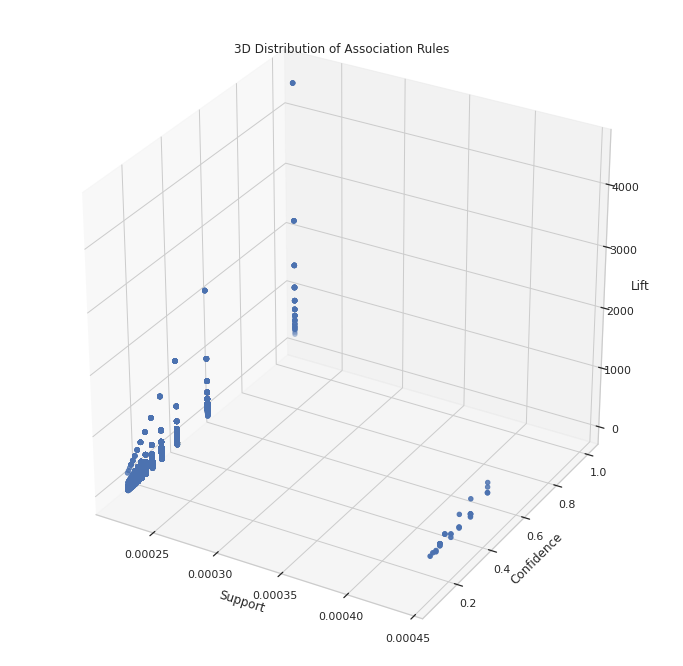

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set(style = "whitegrid")
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection = '3d')


x = rules['support']
y = rules['confidence']
z = rules['lift']

ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_zlabel("Lift")

ax.scatter(x, y, z)
ax.set_title("3D Distribution of Association Rules")

plt.show()